<a href="https://colab.research.google.com/github/Mrcold2002/colab_code/blob/main/3_11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 模型选择，欠拟合，过拟合

## 1 训练误差和泛化误差

- 训练误差：模型在训练集上表现出的误差
- 泛化误差：模型在任一测试数据样本上表现出的误差的期望，通常用在测试集上的误差来近似

## 2 模型选择

评估若干候选模型的表现并从中选择模型

### 验证数据集

严格意义来讲，测试集只能在所有超参数和模型选定后使用一次，因此不可以用测试集来选择模型。因此，我们可以预留一部分数据,称为验证数据集，用来进行模型选择

### k折交叉检验

由于验证数据集不参与模型训练，当训练数据不够用时，预留大量的验证数据集太过奢侈。一种改善方法是k折交叉检验。 

在k折交叉检验中，我们把原石训练数据集分为k个不重复的子数据集，然后我们做k次模型训练和验证。每一次，我们使用一个子数据集验证模型，并使用其它k-1个数据集来训练模型。在这k次训练和验证中，每次用来验证模型子数据集都不同，最后对这k次训练误差和验证误差分别求平均

## 3 欠拟合和过拟合

欠拟合：模型无法得到较低的训练误差
过拟合：模型的训练误差远小于它在测试数据集上的误差

重点讨论两个因素：模型复杂度 和 训练数据集大小

### 模型复杂度

给定训练数据集，如果模型的复杂度过低，很容易发生欠拟合；
如果模型复杂度过高，很容易发生过拟合

### 训练数据集大小

当训练数据集中样本数过少，特别是比模型参数数量更少时，过拟合容易发生，此外，泛化误差不会随训练数据集里样本数量增加而增大。因此，在计算资源允许的范围之内，我们通常希望训练数据集大一些，特别是在模型复杂度较高时，如层数较多的深度学习模型。

## 4 多项式拟合试验

In [5]:
# 0 导入包和模块
%matplotlib inline
from matplotlib import pyplot as plt
from IPython import display
import d2lzh as d2l
from mxnet import autograd,gluon,nd
from mxnet.gluon import data as gdata,loss as gloss,nn

In [15]:
# 1 生成数据集
# 生成人工数据集，以y=1.2*x-3.4*x^2+5.6*x^3+5+z (z是噪声，服从正太分布)
n_train,n_test,true_w,true_b=100,100,[1.2,-3.4,5.6],5
features = nd.random.normal(shape=(n_train+n_test,1))
poly_features=nd.concat(features,nd.power(features,2),nd.power(features,3))
labels=(true_w[0]*poly_features[:,0]+true_w[1]*poly_features[:,1]+true_w[2]*poly_features[:,2]+true_b)
labels+=nd.random.normal(scale=0.1,shape=labels.shape) 

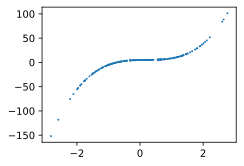

In [7]:
# 展示生成数据
def use_svg_display():
    # 用矢量图显示
    display.set_matplotlib_formats('svg')

def set_figsize(figsize=(3.5, 2.5)):
    use_svg_display()
    # 设置图的尺寸
    plt.rcParams['figure.figsize'] = figsize

set_figsize()
plt.scatter(features.asnumpy(), labels.asnumpy(), 1);  # 加分号只显示图

In [8]:
# 2 定义，训练和测试模型

# 首先定义作图函数semilogy

def semilogy(x_vals, y_vals, x_label, y_label, x2_vals=None, y2_vals=None,
             legend=None, figsize=(3.5, 2.5)):
    d2l.set_figsize(figsize)
    d2l.plt.xlabel(x_label)
    d2l.plt.ylabel(y_label)
    d2l.plt.semilogy(x_vals, y_vals)
    if x2_vals and y2_vals:
        d2l.plt.semilogy(x2_vals, y2_vals, linestyle=':')
        d2l.plt.legend(legend)

In [35]:
# 模型定义
num_epochs, loss = 100, gloss.L2Loss()

def fit_and_plot(train_features, test_features, train_labels, test_labels):
  net=nn.Sequential()
  net.add(nn.Dense(1))
  net.initialize()
  batch_size=min(10,train_labels.shape[0])
  train_iter = gdata.DataLoader(gdata.ArrayDataset(
        train_features, train_labels), batch_size, shuffle=True)
  trainer = gluon.Trainer(net.collect_params(), 'sgd',
                            {'learning_rate': 0.01})
  train_ls,test_ls=[],[]
  for _ in range(num_epochs):
    for X,y in train_iter:
      with autograd.record():
        l=loss(net(X),y)
      l.backward()
      trainer.step(batch_size)
    train_ls.append(loss(net(train_features),train_labels ).mean().asscalar())
    test_ls.append( loss(net(test_features),test_labels ).mean().asscalar())
  print('final epoch:train loss',train_ls[-1],'test loss',test_ls[-1])
  semilogy(range(1,num_epochs+1),train_ls,'epochs','loss',
             range(1,num_epochs+1),test_ls ,['train','test'])
  print('weight:',net[0].weight.data().asnumpy(),
          '\nbias', net[0].bias.data().asnumpy())

final epoch:train loss 0.0045202207 test loss 0.0054060128
weight: [[ 1.1824744 -3.3959026  5.601099 ]] 
bias [4.994114]


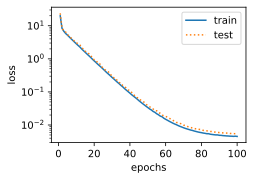

In [36]:
# 三阶函数拟合(正常)
fit_and_plot(poly_features[:n_train, :], poly_features[n_train:, :],
             labels[:n_train], labels[n_train:])

final epoch:train loss 93.91235 test loss 113.33503
weight: [[16.684603]] 
bias [2.2746506]


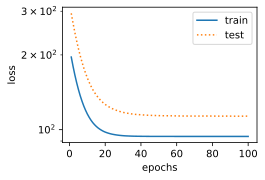

In [37]:
# 线性函数拟合
fit_and_plot(features[:n_train, :], features[n_train:, :], labels[:n_train],
             labels[n_train:])

final epoch:train loss 1.2966912 test loss 348.69534
weight: [[-0.64535385  0.2437686  -0.12066841]] 
bias [2.7242053]


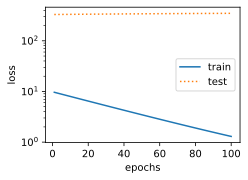

In [39]:
# 样本数量不足，过拟合
fit_and_plot(poly_features[0:2, :], poly_features[n_train:, :], labels[0:2],
             labels[n_train:])

## 5 小结
- 由于无法从训练误差估计泛化误差，一味地降低训练误差并不意味着泛化误差一定会降低。机器学习模型应关注降低泛化误差。
- 可以使用验证数据集来进行模型选择。
- 欠拟合指模型无法得到较低的训练误差，过拟合指模型的训练误差远小于它在测试数据集上的误差。
- 应选择复杂度合适的模型并避免使用过少的训练样本。